# Evaluación de Modelos Alternativos para Predicción de Ventas Mensuales

Este análisis tiene como objetivo comparar diferentes modelos de aprendizaje automático para predecir la variable **venta_mensual**. Se entrenarán y evaluarán múltiples modelos, y se seleccionarán los mejores en función de métricas de error como **MAE (Mean Absolute Error)** y **RMSE (Root Mean Squared Error)**.

Adicionalmente, se aplicará **DBSCAN** para explorar la estructura de los datos y analizar posibles agrupaciones en las ventas mensuales.

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, silhouette_score

## Carga y Preprocesamiento de Datos

En esta sección, cargamos los datos y realizamos las siguientes tareas:

- Eliminación de valores nulos  
- Selección de características relevantes  
- Conversión de variables categóricas si es necesario  
- Escalado de datos para mejorar el rendimiento de los modelos


In [36]:

# Cargamos datos transformados y elminamos valores nulos
df = pd.read_csv('datos_retail_trans.csv')
df.dropna(inplace=True)
X = df.select_dtypes(include=['number'])
y = df['venta_mensual']  # variable objetivo


In [49]:
print(f"Datos después de eliminar nulos: {df.shape}")

Datos después de eliminar nulos: (17010, 25)


In [37]:
# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Construcción de Modelos de Machine Learning

Aquí se entrenan diversos modelos de **Machine Learning** para predecir `venta_mensual`. Se incluyen los siguientes algoritmos:

- Regresión Lineal Múltiple  
- Regresión Ridge
- Árbol de Decisión
- Random Forest
- Support Vector Regression (SVR)  

Cada modelo será evaluado con las métricas **MAE (Mean Absolute Error)** y **RMSE (Root Mean Squared Error)**.


In [38]:
# Modelos de Machine Learning para predecir 'venta_mensual'
# Regresión lineal, árboles de decisión, modelos de ensamble y SVR
models = {
    'Linear Regression': LinearRegression(),
    'Multiple Linear Regression (Ridge)': Ridge(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'SVR': SVR()
}

In [39]:
results = {}

In [40]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[name] = {'MAE': mae, 'RMSE': rmse}

In [42]:
# Convertimos los resultados en un DataFrame para visualización
results_df = pd.DataFrame(results).T
results_df.sort_values(by="RMSE", ascending=True, inplace=True)
print(results_df)

                                             MAE          RMSE
Linear Regression                   1.396036e-11  3.358147e-11
Multiple Linear Regression (Ridge)  2.146866e-08  5.208590e-08
Random Forest                       5.772604e+00  7.828589e+01
Decision Tree                       1.486014e+01  2.918611e+02
SVR                                 1.975738e+03  7.811724e+03


## Comparación de Resultados

Se comparan gráficamente los modelos según su rendimiento en MAE y RMSE. Esto permite identificar cuál modelo tiene menor error y es más adecuado para el problema.

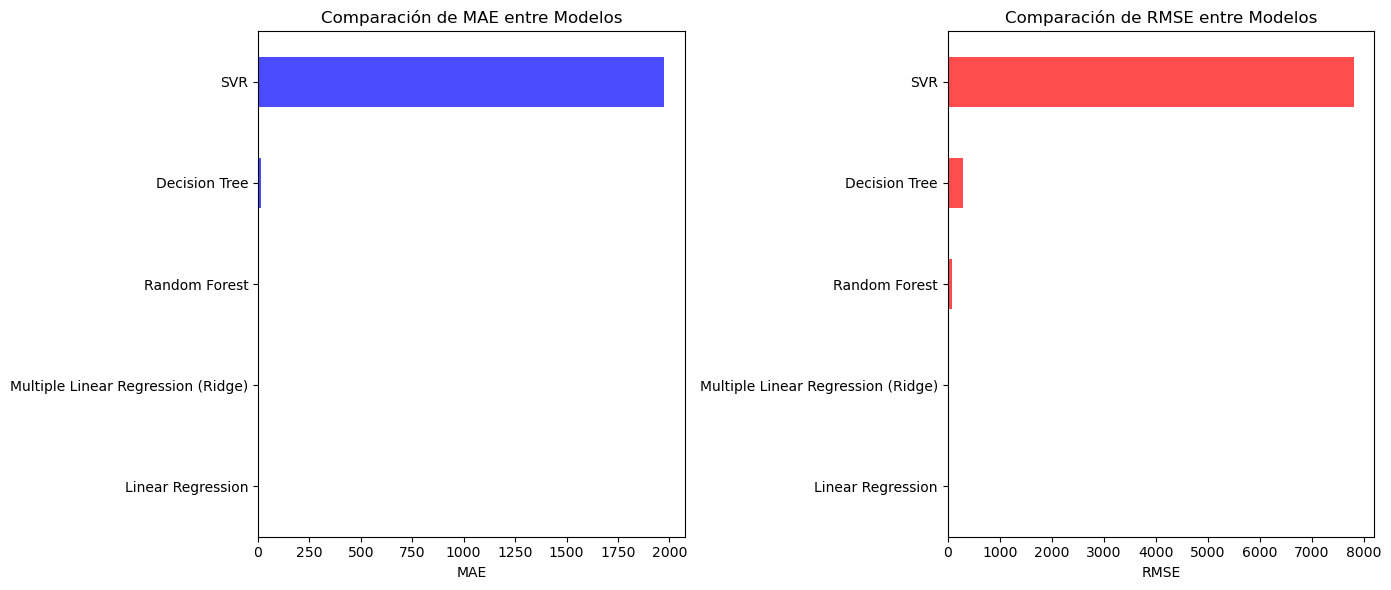

In [43]:
import matplotlib.pyplot as plt

# Crear gráficos de barras para comparar MAE y RMSE
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de MAE
results_df["MAE"].plot(kind="barh", ax=axes[0], color="blue", alpha=0.7)
axes[0].set_title("Comparación de MAE entre Modelos")
axes[0].set_xlabel("MAE")

# Gráfico de RMSE
results_df["RMSE"].plot(kind="barh", ax=axes[1], color="red", alpha=0.7)
axes[1].set_title("Comparación de RMSE entre Modelos")
axes[1].set_xlabel("RMSE")

plt.tight_layout()
plt.show()

## Exploración de Agrupaciones con DBSCAN

DBSCAN es un algoritmo de clustering basado en densidad. Lo utilizaremos para ver si es viable agrupar los datos en clusters.

**Parámetros clave en DBSCAN:**
- **eps (epsilon):** Distancia máxima entre dos puntos para ser considerados vecinos.
- **min_samples:** Número mínimo de puntos requeridos para formar un cluster.

Se evaluará el rendimiento del clustering usando **Silhouette Score**, donde:
- **Valores cercanos a 1** indican clusters bien definidos.
- **Valores cercanos a 0** indican clusters poco distinguibles.
- **Valores negativos** sugieren que los puntos pueden estar mal agrupados.

In [46]:
# Run DBSCAN
X_DBSCAN = df[['venta_mensual', 'precio_mensual', 'volumen_mensual', 'costo_venta_ratio']]

# X_DBSCAN = X.loc[:, X.nunique() > 1]
# Normalizamos los datos para que esten en la misma escala
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_DBSCAN)

# DBSCAN para clustering con columnas seleccionadas
clustering = DBSCAN(eps=5, min_samples=10).fit(X_DBSCAN)
labels = clustering.labels_
if len(set(labels)) > 1:
    silhouette = silhouette_score(X_DBSCAN, labels)
else:
    silhouette = 'N/A'

print("DBSCAN Silhouette Score con columnas seleccionadas:", silhouette)


DBSCAN Silhouette Score con columnas seleccionadas: -0.37316019738244527


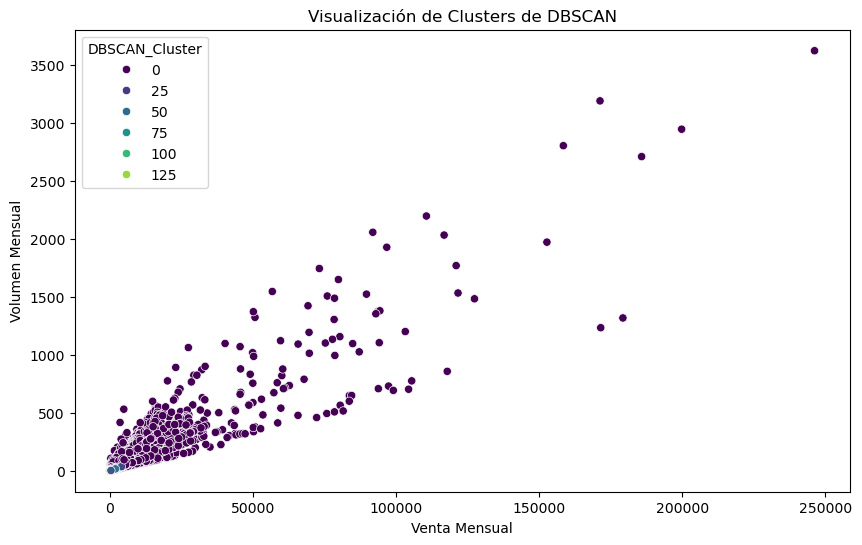

In [50]:
import seaborn as sns

# Agregar etiquetas de clusters al DataFrame original
df['DBSCAN_Cluster'] = labels

# Graficar clusters en un scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['venta_mensual'], y=df['volumen_mensual'], hue=df['DBSCAN_Cluster'], palette="viridis")
plt.title("Visualización de Clusters de DBSCAN")
plt.xlabel("Venta Mensual")
plt.ylabel("Volumen Mensual")
plt.show()

## Conclusiones

1. **Modelos con mejor rendimiento**:
   - Según la métrica RMSE, los modelos de **Regresión Lineal** y **Ridge** tienen los menores errores.
   - **Random Forest** y **Decision Tree** tienen errores mayores, pero aún competitivos.
   - **SVR** tuvo un desempeño muy bajo, indicando que no es una buena opción para este problema.

2. **Interpretación de DBSCAN**:
   - El **Silhouette Score** obtenido indica que los clusters no están bien definidos.
   - En el ejercicio anterior usamos K-Means y tampoco fue muy efectivo
